In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts/

/content/gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts


In [4]:
!pip install segment_anything

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import glob
import os
import copy
import sys
import wandb
from segment_anything import sam_model_registry
sys.path.append('../src')
from model_SAM import my_SAM
from metrics import dice_loss, dice_coefficient, batch_dice_coeff
from datasets import KneeSegDataset2DSAM
from utils import read_hyperparams, path_arr_to_slice_arr

In [6]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# Read in hyperparams from txt file (will keep this in scripts folder)
# Each line in file in format (e.g. learning_rate=0.001)
hyperparams = read_hyperparams('hyperparams_sam.txt')
print(hyperparams)

{'run_name': 'test_sam', 'l_rate': 1e-05, 'num_epochs': 10.0, 'batch_size': 4.0, 'threshold': 0.5}


In [8]:
# Define data path
DATA_DIR = '../data'

# Get the paths
train_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/train/*.im')])
val_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/valid/*.im')])

In [9]:
# Use function in utils to form train/val arrays of info needed to access a specific image slice
# Each element in the new array with contain the path to an image, along with the slice index [[path, index],...]
num_of_slices = 160

train_slice_array = path_arr_to_slice_arr(train_paths, num_of_slices)
val_slice_array = path_arr_to_slice_arr(val_paths, num_of_slices)

In [10]:
# Define the dataset and dataloaders
train_dataset = KneeSegDataset2DSAM(train_slice_array, DATA_DIR)
val_dataset = KneeSegDataset2DSAM(val_slice_array, DATA_DIR, split='valid')
train_loader = DataLoader(train_dataset, batch_size=int(hyperparams['batch_size']), num_workers = 1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, num_workers = 1, shuffle=False)

In [11]:
# Load in SAM with pretrained weights
sam_checkpoint = "../models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [12]:
# Create model, initialising with pretrained SAM parts
model = my_SAM(
    image_encoder=copy.deepcopy(sam.image_encoder),
    prompt_encoder=copy.deepcopy(sam.prompt_encoder),
    mask_decoder=copy.deepcopy(sam.mask_decoder),
)
model.eval();

In [13]:
!pip install torchinfo

In [15]:
from torchinfo import summary

batch_size = 4
summary(model, input_size=(batch_size, 3, 1024, 1024))

Layer (type:depth-idx)                             Output Shape              Param #
my_SAM                                             [4, 1, 200, 256]          --
├─ImageEncoderViT: 1-1                             [4, 256, 64, 64]          3,145,728
│    └─PatchEmbed: 2-1                             [4, 64, 64, 768]          --
│    │    └─Conv2d: 3-1                            [4, 768, 64, 64]          (590,592)
│    └─ModuleList: 2-2                             --                        --
│    │    └─Block: 3-2                             [4, 64, 64, 768]          (7,091,328)
│    │    └─Block: 3-3                             [4, 64, 64, 768]          (7,091,328)
│    │    └─Block: 3-4                             [4, 64, 64, 768]          (7,104,128)
│    │    └─Block: 3-5                             [4, 64, 64, 768]          (7,091,328)
│    │    └─Block: 3-6                             [4, 64, 64, 768]          (7,091,328)
│    │    └─Block: 3-7                             [4, 6

In [25]:
# Specify optimiser
# Only use trainable parameters in optimiser
l_rate = hyperparams['l_rate']
trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Adam(trainable_params, lr=l_rate)

# define bce loss. Will call this and dice loss in train loop, unweighted
loss_bce = nn.BCELoss()

In [26]:
# How long to train for?
num_epochs = int(hyperparams['num_epochs'])

# Threshold for predicted segmentation mask
threshold = hyperparams['threshold']

In [27]:
model.to(device)

# use multiple gpu in parallel if available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [28]:
# Train Loop
for epoch in range(num_epochs):

    # train mode
    model.train()
    running_loss = 0.0
    dice_coeff = 0.0
    n = 0    # counter for num of batches

    # Loop through train loader
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        print("inputs", inputs.shape)
        print("targets", targets.shape)

        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)

        print("outputs", outputs.shape)

        bce = loss_bce(outputs, targets) #binary cross-entropy
        dice = dice_loss(outputs, targets) #dice
        loss = bce + dice #unweighted combination of the two

        # Backward, and update params
        loss.backward()
        optimizer.step()

        running_loss += loss.detach().cpu().numpy()
        dice_coeff += batch_dice_coeff(outputs>threshold, targets).detach().cpu().numpy()
        n += 1

        print(f"bce: {bce}, dice: {dice}, total: {loss}, dice score: {batch_dice_coeff(outputs>threshold, targets).detach().cpu().numpy()}")

    # Get train metrics, averaged over number of images in batch
    train_loss = running_loss/n
    train_dice_av = dice_coeff/n

    # After each batch, loop through validation loader and get metrics
    # set model to eval mode and reset metrics
    model.eval()
    running_loss = 0.0
    dice_coeff = 0.0
    n = 0

    # Perform loop without computing gradients
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            bce = loss_bce(outputs, targets)
            dice = dice_loss(outputs, targets)
            loss = bce + dice

            running_loss += loss.detach().cpu().numpy()
            dice_coeff += batch_dice_coeff(outputs>threshold, targets).detach().cpu().numpy()
            n += 1

    # Val metrics
    val_loss = running_loss/n
    val_dice_av = dice_coeff/n

    print(f"loss: {train_loss}, val loss: {val_loss}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


inputs torch.Size([4, 3, 1024, 1024])
targets torch.Size([4, 1, 200, 256])
outputs torch.Size([4, 1, 200, 256])
bce: 0.6113904714584351, dice: 0.9831997156143188, total: 1.594590187072754, dice score: 0.046147506684064865
inputs torch.Size([4, 3, 1024, 1024])
targets torch.Size([4, 1, 200, 256])
outputs torch.Size([4, 1, 200, 256])
bce: 0.556270182132721, dice: 0.9962210059165955, total: 1.5524911880493164, dice score: 0.0015816667582839727
inputs torch.Size([4, 3, 1024, 1024])
targets torch.Size([4, 1, 200, 256])
outputs torch.Size([4, 1, 200, 256])
bce: 0.4311540126800537, dice: 0.9887224435806274, total: 1.4198764562606812, dice score: 0.25215986371040344
inputs torch.Size([4, 3, 1024, 1024])
targets torch.Size([4, 1, 200, 256])
outputs torch.Size([4, 1, 200, 256])
bce: 0.3366799056529999, dice: 0.9771902561187744, total: 1.3138701915740967, dice score: 0.5
inputs torch.Size([4, 3, 1024, 1024])
targets torch.Size([4, 1, 200, 256])
outputs torch.Size([4, 1, 200, 256])
bce: 0.30034041

OutOfMemoryError: ignored

In [ ]:
# Put in image and show out/mask comparison

im, seg = next(iter(val_loader))

In [ ]:
im = im.to(device)
model.to(device)
out = model(im)

In [ ]:
out = out.detach().cpu()

In [ ]:
batch_dice_coeff(seg,out).item()

0.8352224230766296

(200, 256)


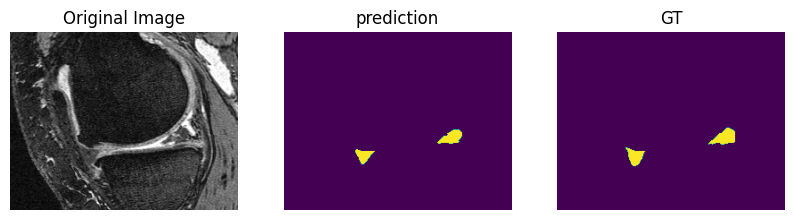

In [ ]:
import matplotlib.pyplot as plt

slice_num = 100

out = out[0][0].detach().cpu().numpy()
binary_mask = (out>0.5).astype(int)
image = im[0][0].detach().cpu().numpy()
gt = seg[0][0]

binary_slice = binary_mask[...,slice_num]
image = image[...,slice_num]
gt = gt[...,slice_num]

print(binary_slice.shape)

# Display the original image and the overlayed image using plt.imshow
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_slice)
ax[1].set_title('prediction')
ax[1].axis('off')

ax[2].imshow(gt)
ax[2].set_title('GT')
ax[2].axis('off')

plt.show()

In [ ]:
def show_mask_slices(img):
    num_subplots = 5
    plt.subplots(num_subplots, num_subplots, figsize = (num_subplots*4, num_subplots*4))

    for cnt, slnum in enumerate(range(0,img.shape[-1],img.shape[-1]//num_subplots**2)):

        if cnt < num_subplots**2:

            plt.subplot(num_subplots, num_subplots, cnt+1)
            plt.imshow(img[...,slnum], cmap = 'gray')
            plt.title('Slice {}'.format(slnum), fontsize= 20)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
seg[0][0].shape

torch.Size([200, 256, 160])

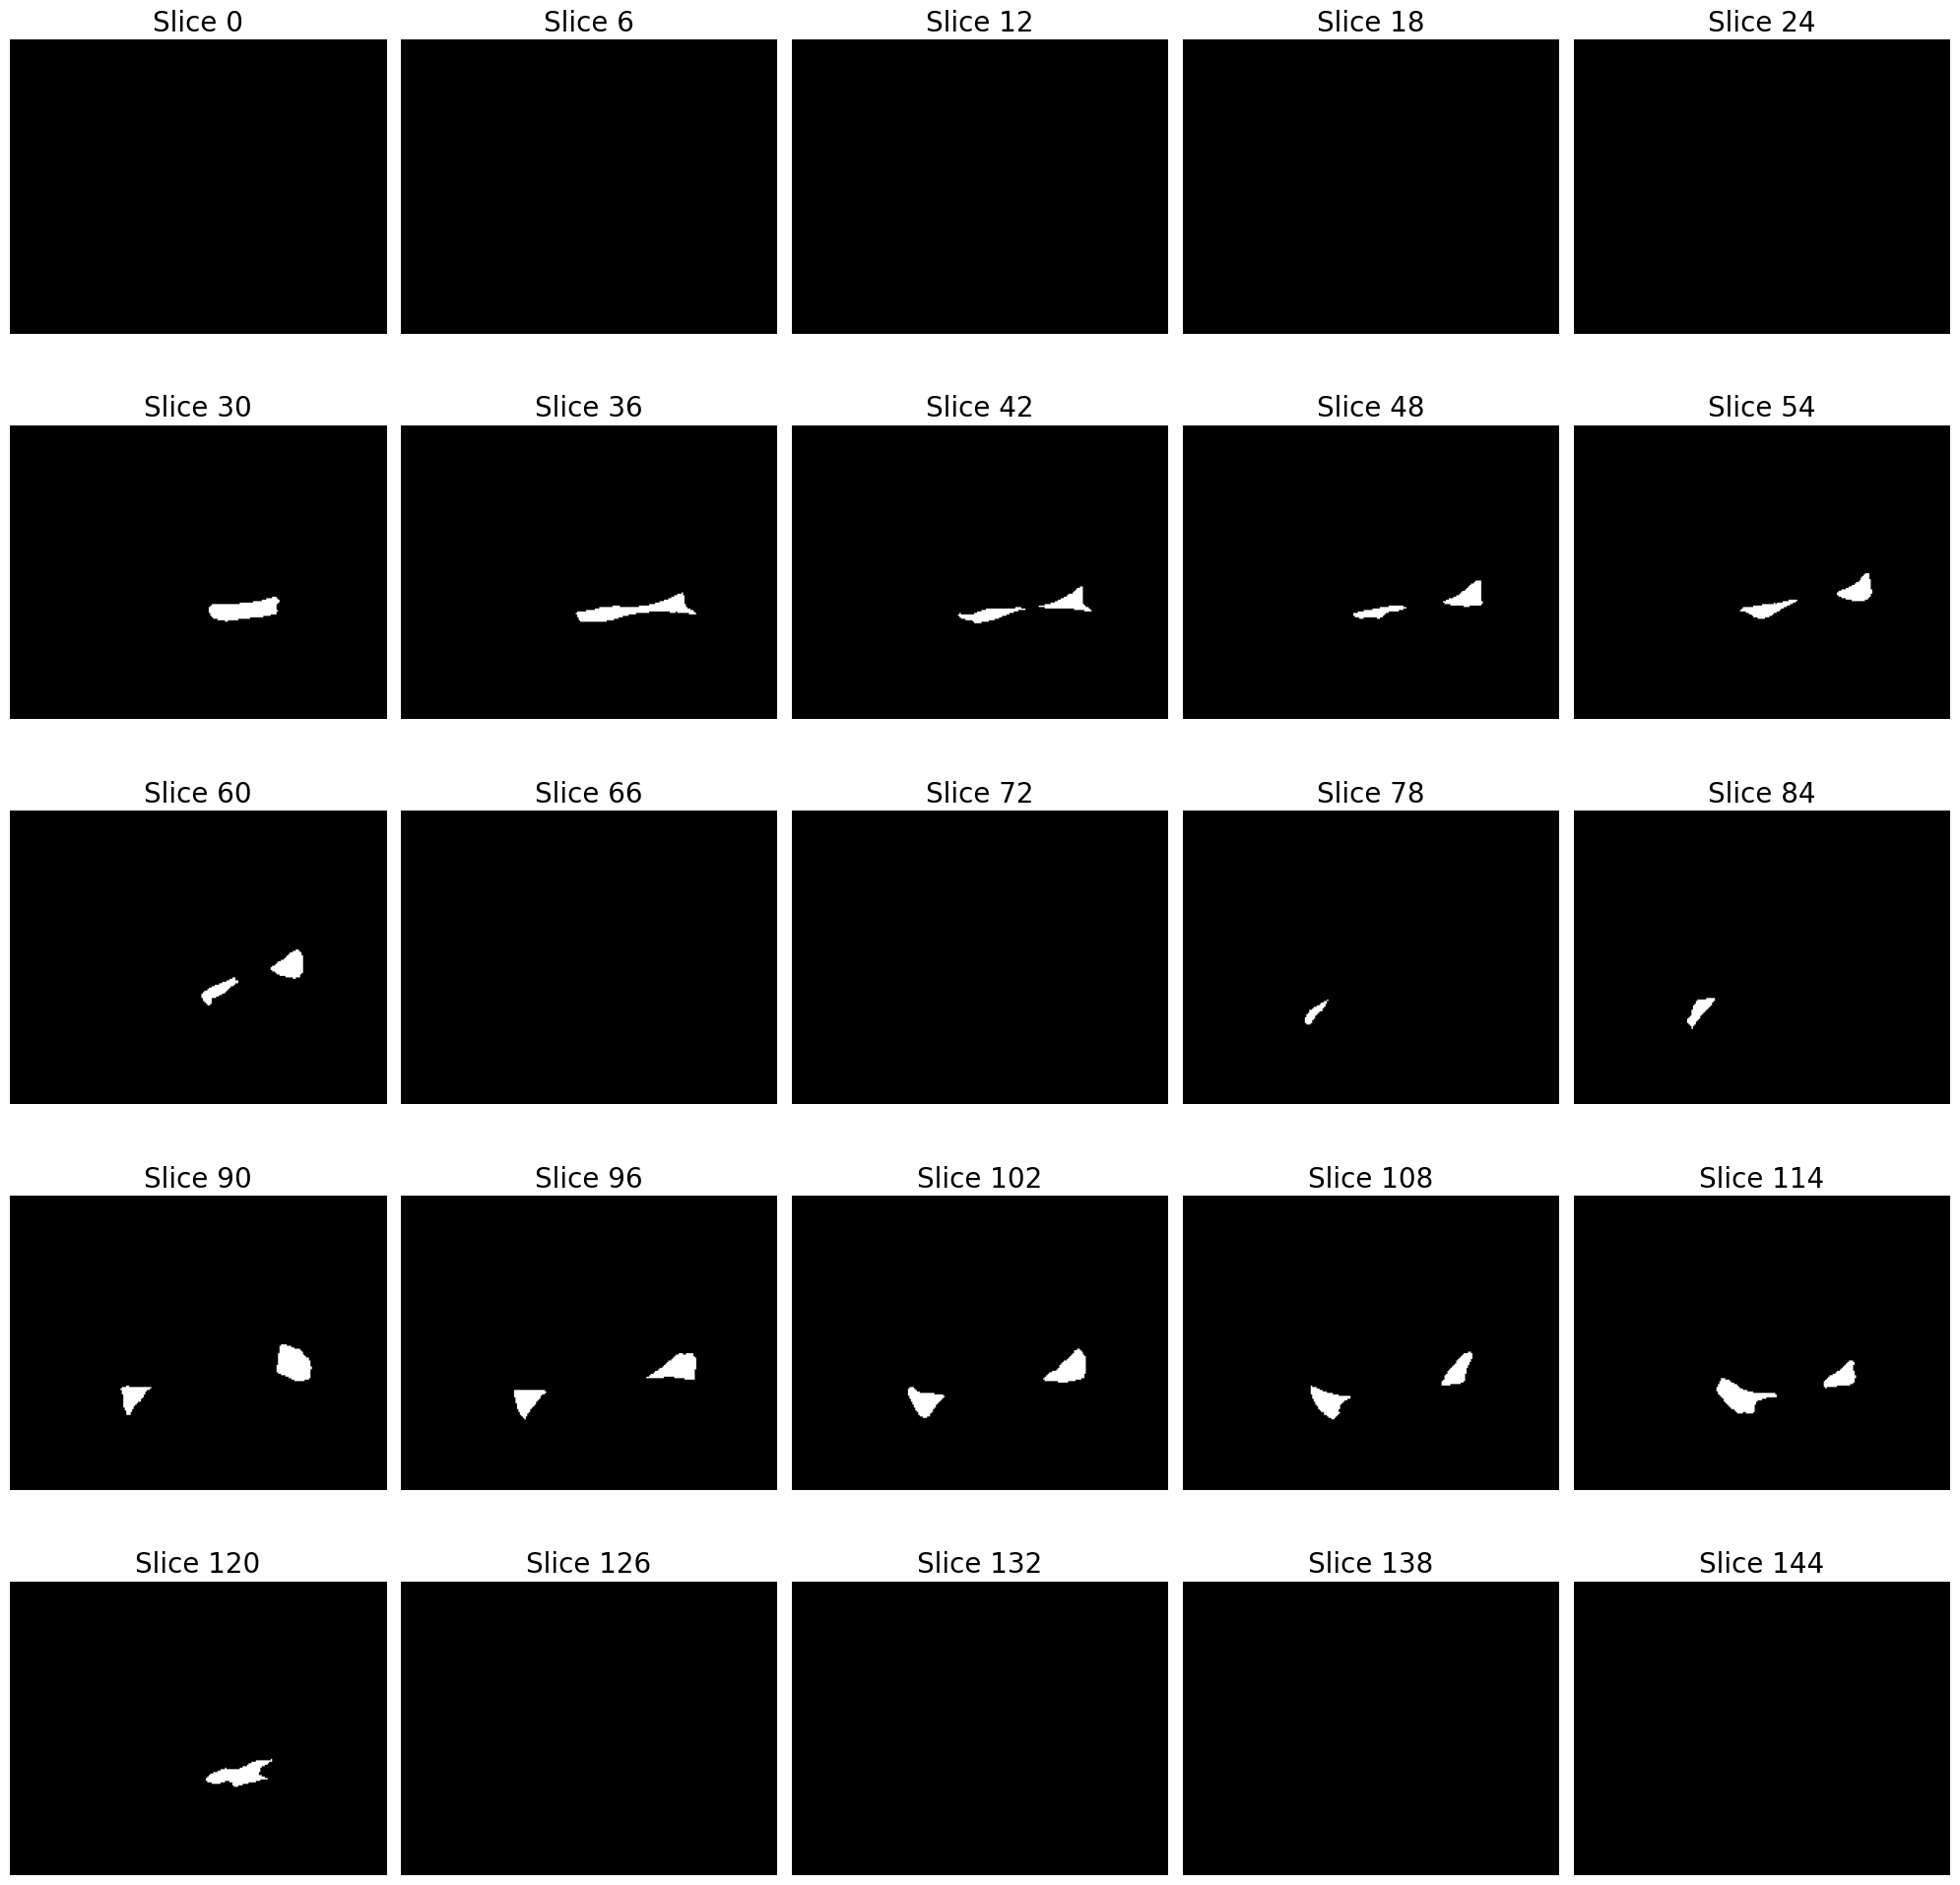

In [ ]:
show_mask_slices(seg[0][0])

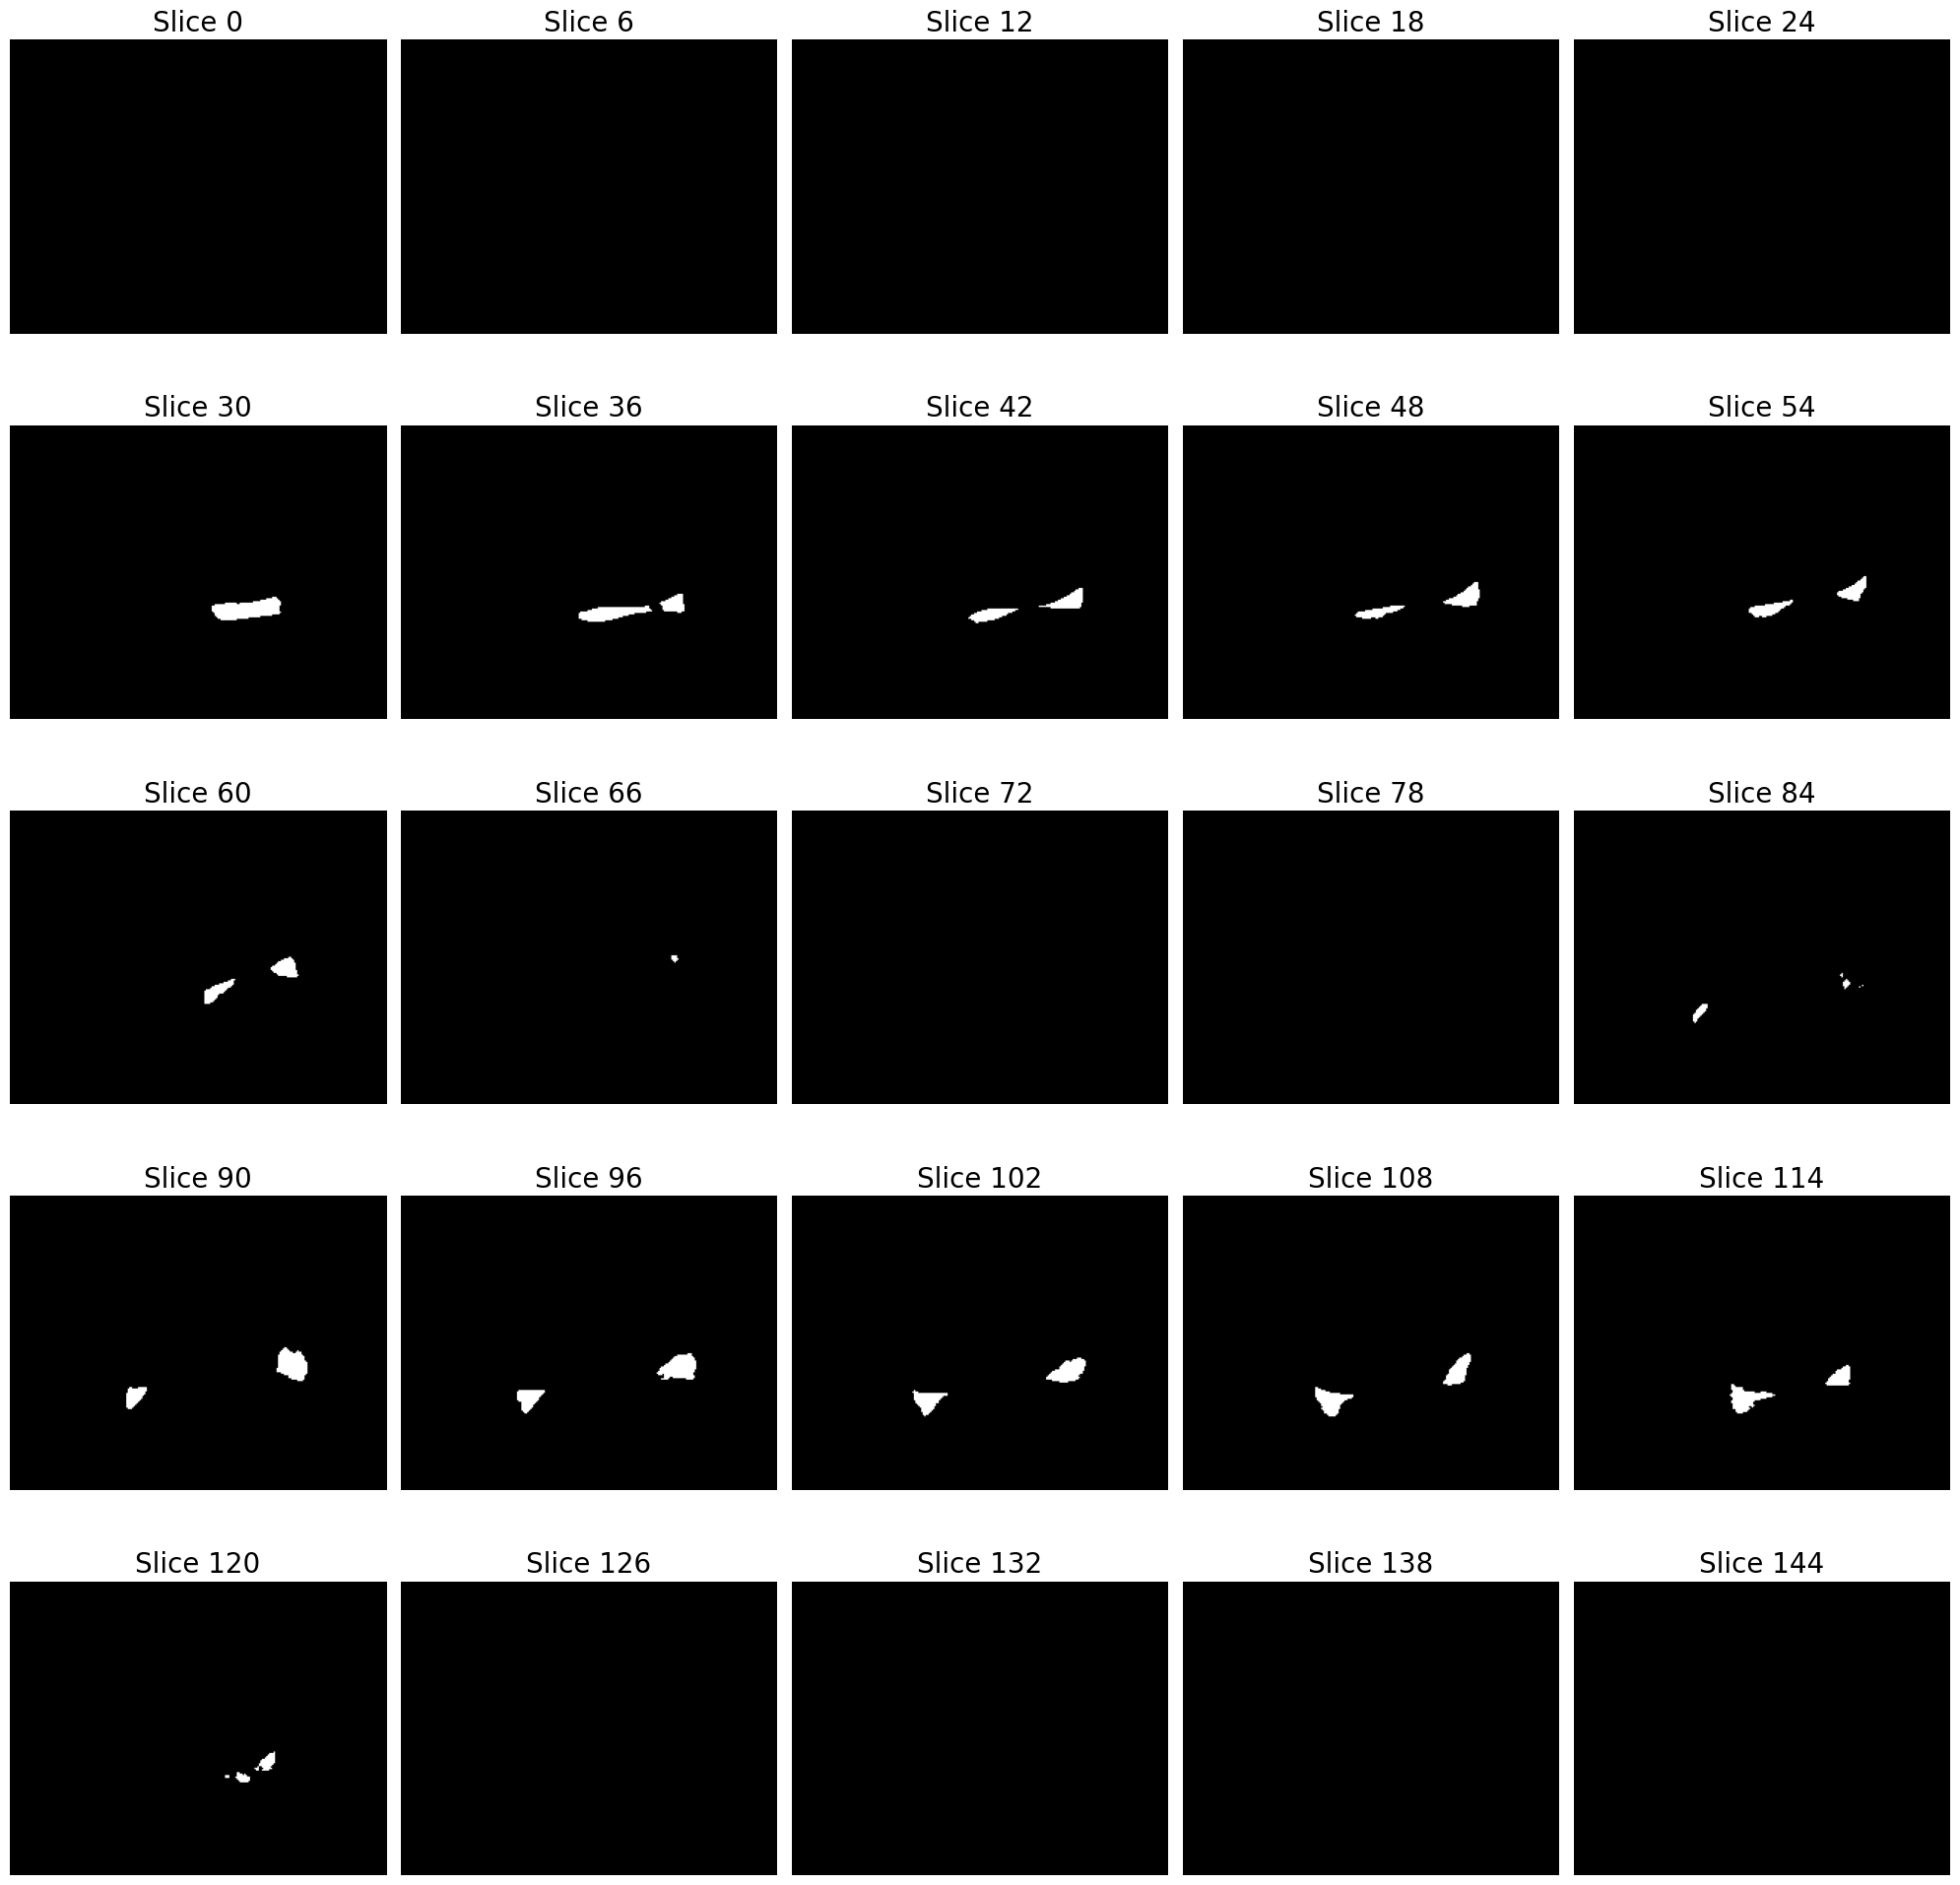

In [ ]:
show_mask_slices(binary_mask)

In [ ]:
seg[0][0].numpy().shape

(200, 256, 160)

In [ ]:
np.save(f'pred_mask_{val_paths[0]}', binary_mask)

In [ ]:
ground = seg[0][0].numpy()

In [ ]:
np.sum(ground.flatten())

39507.0

In [ ]:
np.sum(binary_mask.flatten())

31025

In [ ]:
# get volumes of all masks and predictions to see if it always underpredicts

from tqdm import tqdm

gt_volumes = []
pred_volumes = []
lowest_dice = 1
lowest_dice_idx = -1
count = 0

model.to(device)

for im, mask in tqdm(val_loader):
    im = im.to(device)
    out = model(im)
    out = out.detach().cpu()

    # store volumes of both gt and prediction
    gt_volumes.append(np.sum(mask[0][0].numpy().flatten()))
    pred_volumes.append(np.sum(out[0][0].numpy().flatten()))

    # calculate dice score and overwrite as lowest if it is indeed the lowest
    dice = dice_coefficient(mask, out)
    if dice < lowest_dice:
        lowest_dice = dice
        lowest_dice_idx = count

    # update count
    count += 1



100%|██████████| 28/28 [01:37<00:00,  3.49s/it]


In [ ]:
print(f"Lowest dice score in val set was image {lowest_dice_idx} with score {lowest_dice}")

Lowest dice score in val set was image 27 with score 0.8093818426132202


In [ ]:
print(f"image {lowest_dice_idx} has path {val_paths[lowest_dice_idx]}")

image 27 has path valid_014_V01


In [ ]:
gt_volumes = np.array(gt_volumes)
pred_volumes = np.array(pred_volumes)

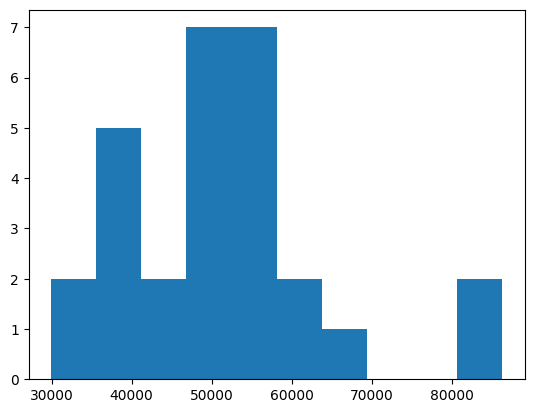

In [ ]:
import matplotlib.pyplot as plt
plt.hist(gt_volumes);

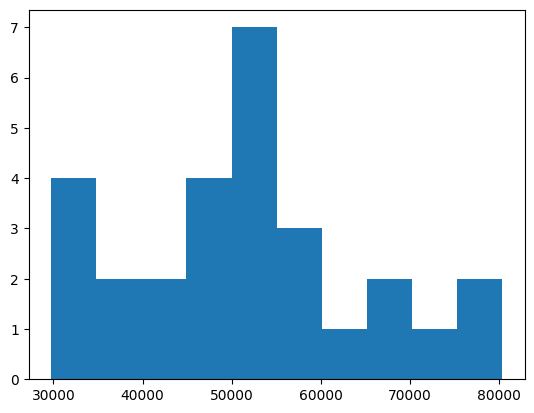

In [ ]:
plt.hist(pred_volumes);

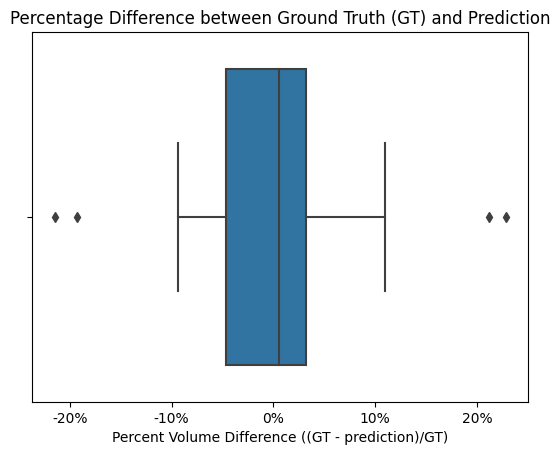

In [ ]:
import seaborn as sns
import matplotlib.ticker as mticker

# They look like they take up a similar range, so let's plot the difference between volumes for each mask
difference = gt_volumes - pred_volumes
pct_diff = difference/gt_volumes

ax = sns.boxplot(x = pct_diff)
plt.xlabel("Percent Volume Difference ((GT - prediction)/GT)")
#plt.ylabel("Difference")
plt.title("Percentage Difference between Ground Truth (GT) and Prediction")

# format x labels as percentages
def percentage_formatter(x, pos):
    return "{:.0f}%".format(x * 100)

# Apply the custom formatter to the x-axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(percentage_formatter))
plt.savefig('pct_diff_volume.png')
plt.show()

In [ ]:
# get data statistics through pandas
import pandas as pd
df = pd.DataFrame({"GT volume": gt_volumes,
                   "Pred volume": pred_volumes,
                   "Absolute pixel diff": difference,
                   "percentage diff": pct_diff})

In [ ]:
df['percentage diff'].describe()

count    28.000000
mean      0.000066
std       0.093420
min      -0.214778
25%      -0.046299
50%       0.005496
75%       0.032352
max       0.228157
Name: percentage diff, dtype: float64

In [ ]:
df['Absolute pixel diff'].describe()

count       28.000000
mean      -151.631699
std       4951.040039
min     -12480.953125
25%      -2448.984375
50%        269.634766
75%       1471.186035
max       9421.937500
Name: Absolute pixel diff, dtype: float64

In [ ]:
df

,GT volume,Pred volume,Absolute pixel diff,percentage diff
0,39507.0,31149.224609,8357.775391,0.211552
1,41075.0,31703.449219,9371.550781,0.228157
2,57996.0,69180.109375,-11184.109375,-0.192843
3,58111.0,70591.953125,-12480.953125,-0.214778
4,50110.0,49215.238281,894.761719,0.017856
5,51733.0,50871.191406,861.808594,0.016659
6,86297.0,76875.062500,9421.937500,0.109180
7,86092.0,80356.507812,5735.492188,0.066620
8,56055.0,56624.242188,-569.242188,-0.010155
9,58746.0,57310.125000,1435.875000,0.024442


In [ ]:
sorted = df.sort_values(by='GT volume')

In [ ]:
sorted

,GT volume,Pred volume,Absolute pixel diff,percentage diff
10,29948.0,30419.046875,-471.046875,-0.015729
11,31321.0,29743.880859,1577.119141,0.050353
26,37364.0,35681.621094,1682.378906,0.045027
27,39153.0,37393.882812,1759.117188,0.044929
0,39507.0,31149.224609,8357.775391,0.211552
18,40291.0,40915.250000,-624.250000,-0.015494
1,41075.0,31703.449219,9371.550781,0.228157
19,42835.0,41757.074219,1077.925781,0.025165
23,45823.0,49083.468750,-3260.468750,-0.071154
20,48087.0,47676.031250,410.968750,0.008546


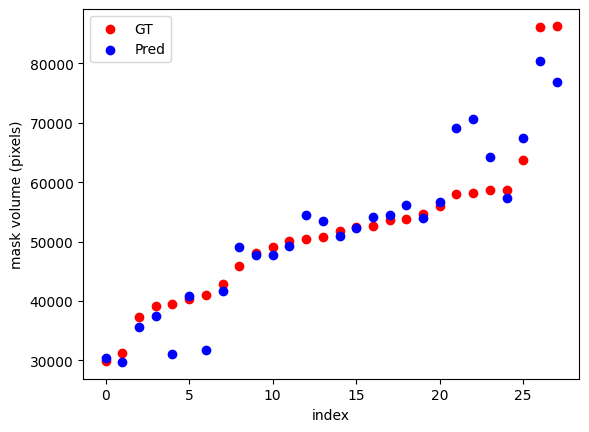

In [ ]:
# plot gt and predictions to see if the under/overestimation is related to volume of GT
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sorted)), sorted['GT volume'], color='r', label='GT')
ax.scatter(np.arange(len(sorted)), sorted['Pred volume'], color='blue', label='Pred')
ax.set_xlabel('index')
ax.set_ylabel('mask volume (pixels)')
ax.legend()
plt.show()

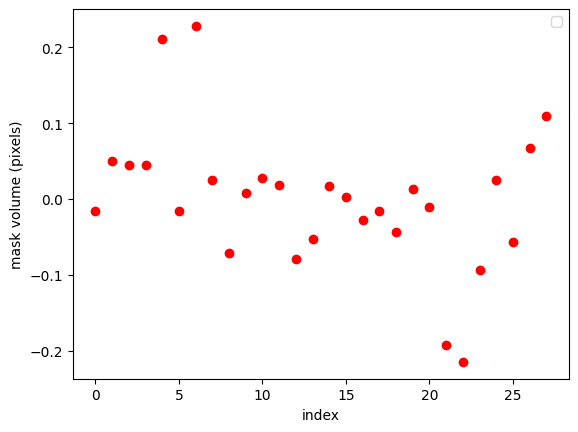

In [ ]:
# plot gt and predictions to see if the under/overestimation is related to volume of GT
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sorted)), sorted['percentage diff'], color='r')
ax.set_xlabel('index')
ax.set_ylabel('mask volume difference (percent)')
ax.legend()
plt.show()